In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "youssefkhattab123" # username from the json file
os.environ['KAGGLE_KEY'] = "3bdb5ec70c98be8ba9a8e28179dcbea3" # key from the json file

In [ ]:
!kaggle datasets download -d obulisainaren/multi-cancer

100% 8.62G/8.62G [01:08<00:00, 127MB/s]
100% 8.62G/8.62G [01:08<00:00, 134MB/s]


In [ ]:
!unzip "/content/multi-cancer.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0002.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0003.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0004.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0005.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0006.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0007.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0008.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0009.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0010.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0011.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0012.jpg  
  inflating: /content/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0013.jpg  
  inflating: /content/Multi Cancer/Or

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [ ]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break

    return noOfClasses,class_names, train_generator, validation_generator

In [ ]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Large(#vgg16, dense,
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
def  initiateModel(noOfClasses):
  #download pre-trained Alexnet model from ImageNet weights
  model = models.alexnet(pretrained=True)

  #freeze the model parameters to avoid backpropagation through them
  for param in model.parameters():
      param.requires_grad = False

  #define the last layer of Alexnet model (classifier)
  num_ftrs = model.classifier[2].in_features #get the number of input features from the last layer of classifier
  model.classifier[2] = nn.Linear(num_ftrs, 2) #replace the last layer with a linear layer with two output classes
  model.train()
  return model

In [ ]:
def intiateParam2(model):
  criterion = nn.CrossEntropyLoss() #define cross entropy loss function
  optimizer = optim.Adam(model.classifier[2].parameters(), lr=0.001, momentum=0.9)
  model_ft = (model, criterion, optimizer, 0.001,
                       num_epochs=25)
  return criterion,optimizer

SyntaxError: ignored

In [ ]:

model = train_model(model, criterion, optimizer, 0.001,
                       num_epochs=25)

In [ ]:
def initiateParams(className, model, lr):
  # Sparse categorical / Binary
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'VGG.h5', verbose=1, save_best_only=True)

    return model, annealer, checkpoint

In [ ]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )

    return history

In [ ]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [ ]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)

def saveModel(model, className):
    model.save(className + " - VGG.h5")
    print("Model Saved!")

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [ ]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [ ]:
mpath = r'/content/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)


Oral Cancer
Lung and Colon Cancer
Kidney Cancer
ALL
Breast Cancer
Cervical Cancer
Lymphoma
Brain Cancer



Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AttributeError: ignored

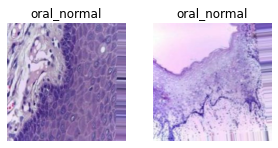

In [ ]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
import os
mpath = r'/content/Multi Cancer'
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import transforms

# Set Up Image Generator
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
data_generator = image_generator.flow_from_directory(cpath, target_size=(224, 224), batch_size=64, class_mode='categorical')
data_loader = torch.utils.data.DataLoader(data_generator, batch_size=64, shuffle=True)

 # Load Pretrained Alexnet Model
model = models.alexnet(pretrained=True)

 # Set Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

 # Train Model on Data Generated by Image Generator
for epoch in range(10):

    running_loss = 0
    i=0

    for images, labels in data_loader:

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer .step()

        running_loss += loss
        i=i+1
        print(i)

    #print('Epoch {} - Training Loss: {:4f}'.format(epoch+1, running_loss/len(data)))


Found 10002 images belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

RuntimeError: ignored

# **Another Model**

---


In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

densenet = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(densenet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-4)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    train_generator,
      validation_data=validation_generator,
      epochs=20,
      batch_size=32,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9006

251/251 [==============================] - 197s 647ms/step - loss: 0.2460 - accuracy: 0.9006 - val_loss: 0.0942 - val_accuracy: 0.9655 - lr: 1.0000e-04
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9774

251/251 [==============================] - 154s 615ms/step - loss: 0.0660 - accuracy: 0.9774 - val_loss: 0.0864 - val_accuracy: 0.9675 - lr: 1.0000e-04
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9830

251/251 [==============================] - 154s 614ms/step - loss: 0.0503 - accuracy: 0.9830 - val_loss: 0.0673 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9873

251/251 [==============================] - 154s 614ms/step - loss: 0.0372 - accuracy: 0.9873 - val_loss: 0.1182 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9938

251/251 [==============================] - 154s 614ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0577 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9965

251/251 [==============================] - 154s 613ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0954 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9890

251/251 [==============================] - 154s 614ms/step - loss: 0.0322 - accuracy: 0.9890 - val_loss: 0.0679 - val_accuracy: 0.9770 - lr: 1.0000e-04
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9893

251/251 [==============================] - 154s 613ms/step - loss: 0.0291 - accuracy: 0.9893 - val_loss: 0.0817 - val_accuracy: 0.9705 - lr: 1.0000e-04
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9925

251/251 [==============================] - 154s 613ms/step - loss: 0.0244 - accuracy: 0.9925 - val_loss: 0.0567 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9860

251/251 [==============================] - 154s 613ms/step - loss: 0.0395 - accuracy: 0.9860 - val_loss: 0.0647 - val_accuracy: 0.9785 - lr: 1.0000e-04
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9959

251/251 [==============================] - 154s 613ms/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.0509 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9974

251/251 [==============================] - 154s 613ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0980 - val_accuracy: 0.9785 - lr: 1.0000e-04
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9930

251/251 [==============================] - 154s 614ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0786 - val_accuracy: 0.9815 - lr: 1.0000e-04
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9971

251/251 [==============================] - 155s 616ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 0.0814 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 15/20
251/251 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9896

251/251 [==============================] - 154s 614ms/step - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.1376 - val_accuracy: 0.9580 - lr: 1.0000e-04
Epoch 16/20
251/251 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9951

251/251 [==============================] - 154s 612ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.0554 - val_accuracy: 0.9845 - lr: 1.0000e-04
Epoch 17/20
251/251 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9870

251/251 [==============================] - 154s 614ms/step - loss: 0.0391 - accuracy: 0.9870 - val_loss: 0.0762 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 18/20
251/251 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9969

251/251 [==============================] - 154s 613ms/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0714 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 19/20
251/251 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9994

251/251 [==============================] - 154s 613ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.0518 - val_accuracy: 0.9855 - lr: 1.0000e-04
Epoch 20/20
251/251 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985

251/251 [==============================] - 154s 613ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.1676 - val_accuracy: 0.9500 - lr: 1.0000e-04


In [ ]:
model.save(className + " - Alexnet.h5")